My goal is to study Austin bikeshare ridership patterns. I would also like to examine the effects of different weather on these ridership patters. In order to perform this analysis, I will be using 2 datasets. 
  * I will be using the [Austin bikeshare](https://www.kaggle.com/jboysen/austin-bike) dataset. This dataset contains information on 649k bikes rides.
  * In order to understand the effects of the weather on ridership, I will be examining the [Austin weather](https://www.kaggle.com/grubenm/austin-weather) dataset.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import thinkplot
import thinkstats2

%matplotlib inline
sns.set()

In [2]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

In [4]:
df.columns

Index(['bikeid', 'checkout_time', 'duration_minutes', 'end_station_id',
       'end_station_name', 'month', 'start_station_id', 'start_station_name',
       'start_time', 'subscriber_type', 'trip_id', 'year'],
      dtype='object')

In [3]:
df.describe()

,bikeid,duration_minutes,end_station_id,month,start_station_id,trip_id,year
count,648508.000000,649231.000000,629389.000000,618479.000000,630190.000000,6.492310e+05,618479.000000
mean,471.615214,29.127506,2582.470617,5.887185,2584.238288,5.384945e+09,2015.340026
std,323.588379,87.278642,319.898534,3.206358,320.840964,4.925349e+09,1.019771
min,3.000000,0.000000,1001.000000,1.000000,1001.000000,8.269930e+06,2013.000000
25%,208.000000,8.000000,2499.000000,3.000000,2501.000000,1.274709e+07,2014.000000
50%,417.000000,15.000000,2548.000000,5.000000,2549.000000,9.900028e+09,2015.000000
75%,745.000000,28.000000,2571.000000,9.000000,2571.000000,9.900190e+09,2016.000000
max,5089.000000,21296.000000,3687.000000,12.000000,3687.000000,9.900353e+09,2017.000000


Notice the minimum and maximum values achieved in the **duration_minutes** column.

The minimum value is 0 minutes. These could be an incorrect value, or it could be a correct value for rides that were terminated immediately after starting. The maximum value is 21296, which is a trip lasting over 350 hours! This is almost certainly an error. This table also shows that 75% of the trips within the dataset last less than 28 minutes.


We should examine what fraction of the dataset contains anomalous rides and decide how to treat these rows.

In [5]:
duration_0_mins = df[df['duration_minutes'] == 0]
frac_of_dataset = 100 * len(duration_0_mins) / len(df)

print('{0:.1f}% of trips in raw data are 0 minutes in duration'.format(frac_of_dataset))

1.7% of trips in raw data are 0 minutes in duration


As such a small fraction of the dataset contains rides of 0 minute duration, lets filter these trips out, thereby treating them as invalid rides.

In [6]:
# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

Lets do the same for trips lasting longer than 2 hours.

In [7]:
greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

print('{0:.1f}% of trips in remaining data are greater than 120 minutes in duration'.format(frac_of_dataset))

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

3.3% of trips in remaining data are greater than 120 minutes in duration


Let's spend some time examining the **start_time** column, which tells us when individual bike trips started. 

First, let's convert the string based column to a datetime type, and then let's look at counts of trips by start time hour.

In [9]:
# convert start_time column to datetime type
df['start_time'] = pd.to_datetime(df['start_time'])

# Pull out hour of day into a seperate column
df['start_hour'] = df['start_time'].apply(lambda t: t.hour)

# Count the number of trips that start by hour
hourly_counts = df['start_hour'].value_counts()

# reorder by hour of day
hourly_counts.sort_index(inplace=True)

# Return a DataFrame with the index as an additional column
hourly_counts_df = hourly_counts.reset_index()

# preview it for ease of understanding
hourly_counts_df.head()

,index,start_hour
0,0,7215
1,1,4968
2,2,4946
3,3,971
4,4,654


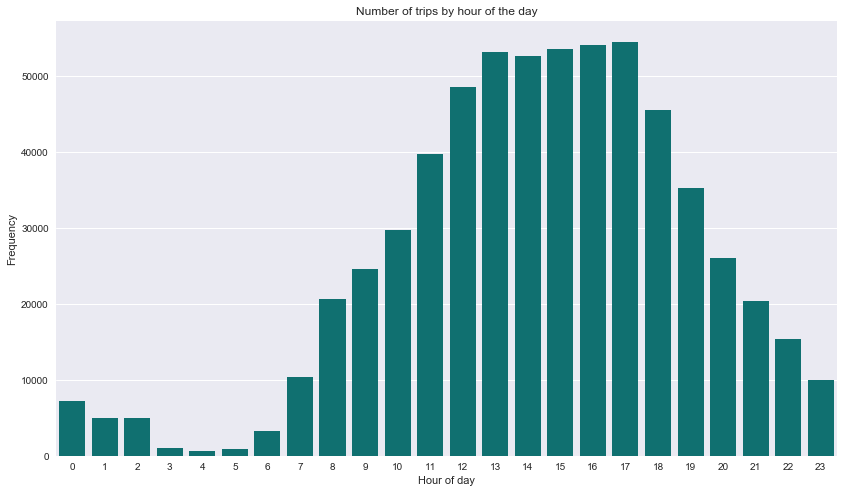

In [13]:
ax = sns.barplot(x='index', y='start_hour', data=hourly_counts_df, color='teal')

ax.figure.set_size_inches(14,8)
ax.set_title('Number of trips by hour of the day')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Frequency')

plt.show()

Here we have a histogram of the number of biketrips by the hour of the day. Notice that there are many more trips during daytime hours than there are during early morning hours. This makes sense, as most people aren't taking bike rides while there asleep.

As we continue our exploration, it will make sense to create this plot for different days of the week to study the effect of day of the week on bike trips by hour. Let's hold off on that for now and continue to perform our exploration of single variable distributions.

Let's have a look at the **duration_minutes** column. Let's bin this column into 5 minute bins, and plot a histogram of the counts for each of these bins.

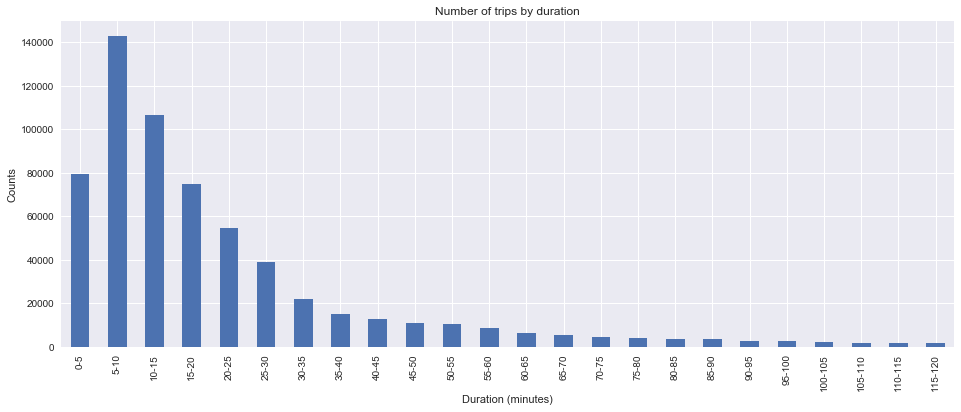

In [11]:
# Select the bin intervals
bins = np.arange(0,125,5)

# Return indices of half-open bins to which each value of column belongs.
duration_min_intervals = pd.cut(df['duration_minutes'], bins=bins, include_lowest=True)
five_minute_counts = duration_min_intervals.value_counts(sort=False)

# Create the plot
ax = five_minute_counts.plot.bar(rot=90, figsize=(16, 6))

# Formatting
ax.set_title('Number of trips by duration')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Counts')

# Format x tick labels
labels = ['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
ax.set_xticklabels(labels)

plt.show()

What this plot demonstrates is that the number of bike rides falls off quickly with the length of the ride. Most rides are between 5-10 minutes in length, suggesting riders are using the bikeshare service to take quick rides to travel to and from different locations. Fewer riders are using the service for longer "joyrides". 

Again, it will be interesting to segment our bike rides by day of the week and take a look at how this plot changes.

In order to begin our examination of the effect that day of the week has on ridership patters, let's compute the mean trip duration for each day of the week and plot the distributions for each day of the week. This will also allow us to examine the mean trip duration for weekdays versus weekend trips.

In [14]:
# Pull out start day of the week into a seperate column where Monday=0, Sunday=6
df['start_day_of_week'] = df['start_time'].apply(lambda t: t.dayofweek)

# Group the rows by the start_day_of_week and compute summary statistics
df.groupby('start_day_of_week')['duration_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
start_day_of_week,,,,,,,,
0,74269.0,19.775236,20.098680,1.0,7.0,13.0,24.0,120.0
1,65626.0,17.606604,18.937446,1.0,6.0,11.0,21.0,120.0
2,67188.0,17.403703,18.351631,1.0,6.0,11.0,21.0,120.0
3,72337.0,18.139140,19.004834,1.0,7.0,11.0,22.0,120.0
4,97297.0,20.706024,20.095758,1.0,8.0,14.0,25.0,120.0
5,132552.0,25.336313,22.268594,1.0,11.0,18.0,30.0,120.0
6,107812.0,25.305263,22.508104,1.0,10.0,18.0,31.0,120.0


Notice that the mean and median trip durations for Saturday and Sunday are larger than those for the remaining days of the week. However, it's hard to see the bigger picture by just looking at a table of numbers. 

We can visualize these differences by day by plotting violin plots, which help us to compare numerical data (trip duration) across categories (days of the week).

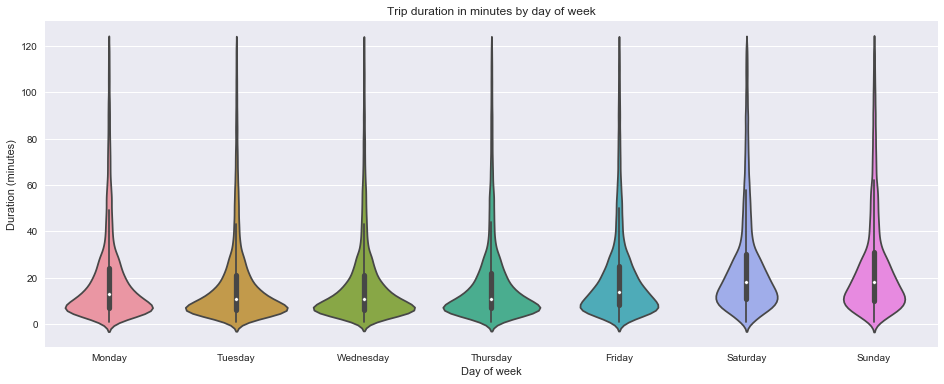

In [15]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

sns.violinplot(x="start_day_of_week", y="duration_minutes", data=df, ax=ax)

ax.set_title('Trip duration in minutes by day of week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Duration (minutes)')
ax.set_xticklabels(days)

plt.show()

Notice that the distribution of trip durations ocurring during weekday trips are similar in both the shape of the distribution and the median duration. These distributions are unimodal and have similar centers, suggesting that most rides occur at the same time of each day, and are right skewed, suggesting that most trips have short durations, but that there are trips that last much longer in duration.

The shape of the daily distributions flattens out a bit on Fridays and is flattest on Saturday and Sunday, demonstrating higher spread a.k.a. higher variability in the duration of a trip. The median trip duration also increases on Friday and is highest on Saturday and Sunday, which points towards different ridership patterns on weekdays versus weekends.

In fact, we might begin to characterize weekend bike rides as being more "joy ride-esque", as these trips tend to be longer than typical weekday rides.

Let's go back and examine the number of bike trips. This time, we will incorporate the day of the week information to look more closely at ridership patterns. We will examine this difference a bit more closely by using the concept of probability mass functions to compare hourly rides for weekday versus weekend rides.

In [16]:
# Monday=0, Sunday=6
weekday_rides = df[df['start_day_of_week'] < 5]
weekend_rides = df[df['start_day_of_week'] >= 5]

# Count the number of trips that start by hour
weekday_hourly_counts = weekday_rides['start_hour'].value_counts()
weekend_hourly_counts = weekend_rides['start_hour'].value_counts()

# reorder by hour of day
weekday_hourly_counts.sort_index(inplace=True)
weekend_hourly_counts.sort_index(inplace=True)

# Return a DataFrame with the index as an additional column
weekday_hourly_counts_df = weekday_hourly_counts.reset_index()
weekend_hourly_counts_df = weekend_hourly_counts.reset_index()

weekday_hourly_counts_df['normalized'] = weekday_hourly_counts_df['start_hour'] / weekday_hourly_counts_df['start_hour'].sum()
weekend_hourly_counts_df['normalized'] = weekend_hourly_counts_df['start_hour'] / weekend_hourly_counts_df['start_hour'].sum()

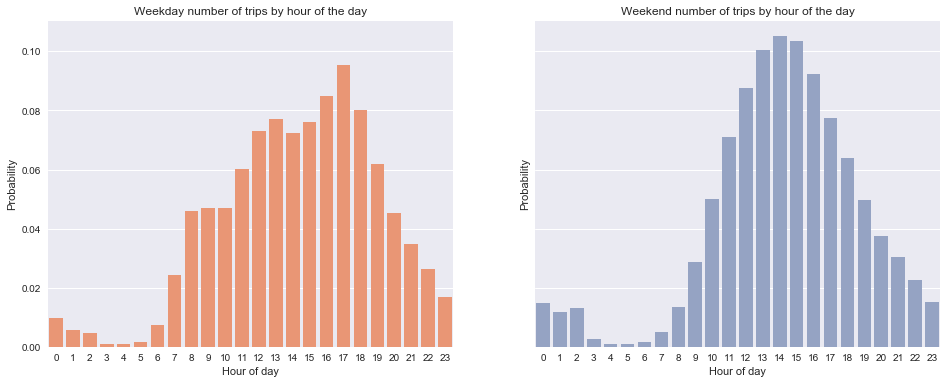

In [18]:
hex_colors = sns.color_palette("Set2", 10).as_hex()

# Note the sharey boolean parameter here to ensure the y axis is shared
fig, ax = plt.subplots(1, 2, figsize=(16,6), sharey=True)

sns.barplot(x='index', y='normalized', data=weekday_hourly_counts_df, color=hex_colors[1], ax=ax[0])
sns.barplot(x='index', y='normalized', data=weekend_hourly_counts_df, color=hex_colors[2], ax=ax[1])

ax[0].set_title('Weekday number of trips by hour of the day')
ax[1].set_title('Weekend number of trips by hour of the day')

for i in range(2):
    ax[i].set_xlabel('Hour of day')
    ax[i].set_ylabel('Probability')

plt.show()

Notice the different shapes of the distributions for weekday vs. weekend rides. The weekend distribution is unimodal with a peak between 1-3 pm. This peak doesn't exist on weekdays; instead the trips are much more uniformly spread with the most trips occurring at 5 pm, during the afterwork commute periods. Also, the probability of bike trips increases in large steps at 7 am when many commutes to work begin, and then again at 8, 9, and 10 am. The probability of a trip then increases and stay fairly level until the afterwork commute. This increase occurs more smoothly on the weekend.

During the weekend there are more trips occuring during the early morning hours (midnight-3 am) on than during weekdays. People are being responsible ;)

We can dig even further into these differences by treating the start time variables as a continuous quantity and using kernel density estimation to estimate a smooth probability density function for each day of the week.

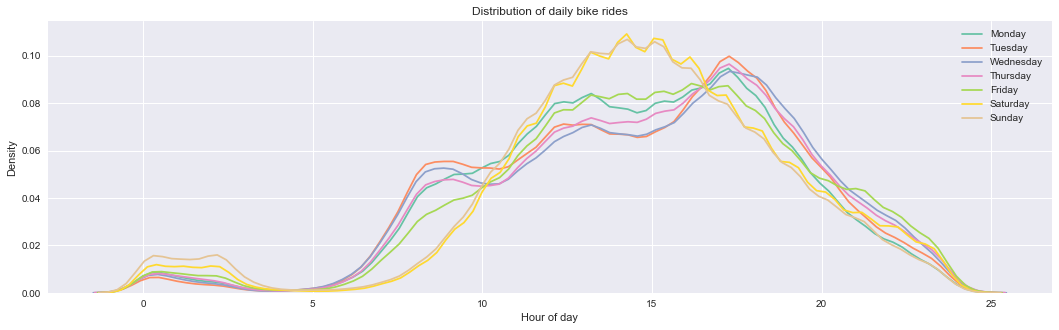

In [20]:
df['hour_fractional'] = df['start_time'].apply(lambda t: t.hour + (t.minute/60.0))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))

for i in range(7):
    day_i = df[df['start_day_of_week'] == i]
    sns.distplot(day_i['hour_fractional'], hist=False, label=days[i], ax=ax, color=hex_colors[i])
    plt.legend()
    
ax.set_title('Distribution of daily bike rides')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Density')
    
plt.show()

Really interesting. You can almost see the ridership patterns morph throughout the week. Notice how Friday seems a bit different from both Monday-Thursday and Saturday-Sunday. You can literally see the weekend arriving using bikeshare data.

Similarly, let's compare the distributions of trip durations by comparing these for weekday and weekend trips. We can compare these by plotting the cumulative distribution function for the weekday and weekend.

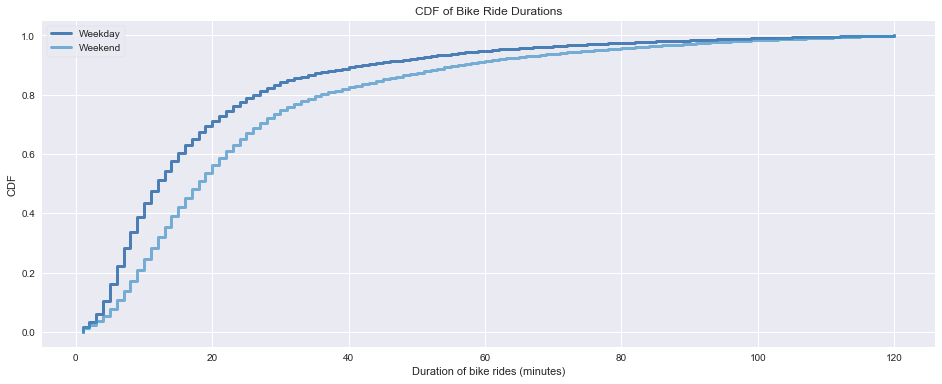

In [43]:
weekday_cdf = thinkstats2.Cdf(weekday_rides['duration_minutes'], label='Weekday')
weekend_cdf = thinkstats2.Cdf(weekend_rides['duration_minutes'], label='Weekend')

plt.figure(figsize=(16,6))
thinkplot.PrePlot(2)
thinkplot.Cdfs([weekday_cdf, weekend_cdf])
thinkplot.Config(title='CDF of Bike Ride Durations', 
                 xlabel='Duration of bike rides (minutes)', ylabel='CDF')

We can see that weekday trips tend to be shorter than weekend trips. We see that 60% of weekday trips last shorter than ~15 minutes while 60% of trips last less than ~22 minutes on the weekend. This plot makes this difference really apparent.

### Weather Analysis

In [47]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_weather.csv')

# Replace values with NaNs
df.replace('-', np.nan, inplace=True)
df.replace('T', np.nan, inplace=True)

# Convert column types to float
for col in df:
    if col != 'Date' and col != 'Events':
        df[[col]] = df[[col]].astype(float)
        
# Convert the column type to the datetime type
df['Date'] = pd.to_datetime(df['Date'])
# Set the index to that column
df.index = df['Date']
del df['Date']

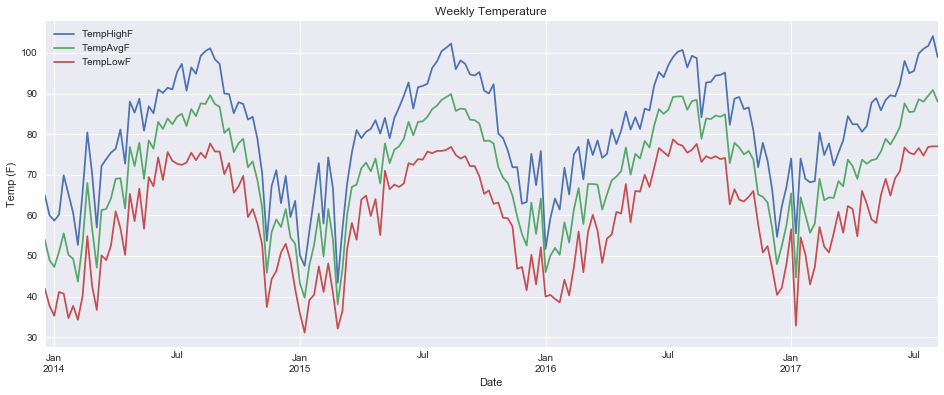

In [48]:
df[['TempHighF', 'TempAvgF', 'TempLowF']].resample('W').mean().plot(title='Weekly Temperature', figsize=(16, 6))

plt.ylabel('Temp (F)')
plt.show()

The above plot demonstrates the seasonality of the weather in Austin. The average temperature is around 50 degrees only about 2-4 months of the year (November - February). The weekly low temperarture always stays above 30 degrees in this span of time.

By May the weekly avg temperature has already hit 70 degrees and remains there until October/November.

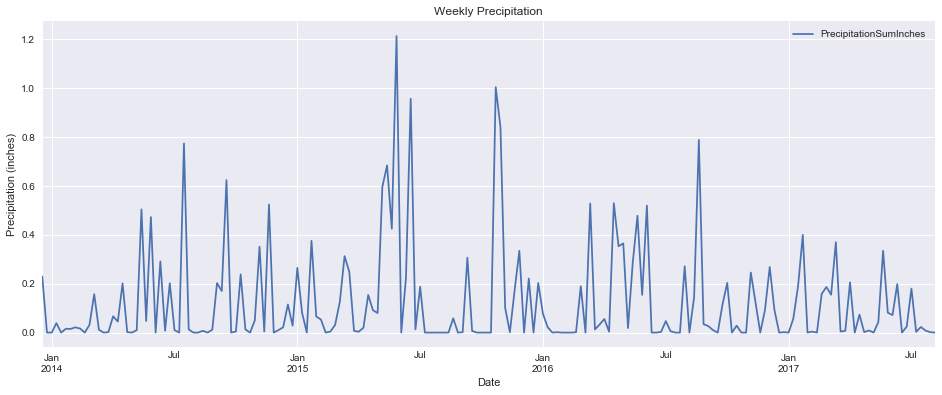

In [49]:
df[['PrecipitationSumInches']].resample('W').mean().plot(title='Weekly Precipitation', figsize=(16, 6))

plt.ylabel('Precipitation (inches)')
plt.show()

The weekly precipitation is less seasonal than the temperature. However, we do see spikes in the months May, June, July of each year. The months of May-July 2016 had the highest average precipitation. A similar period of high average precipitation was observed in November 2016.

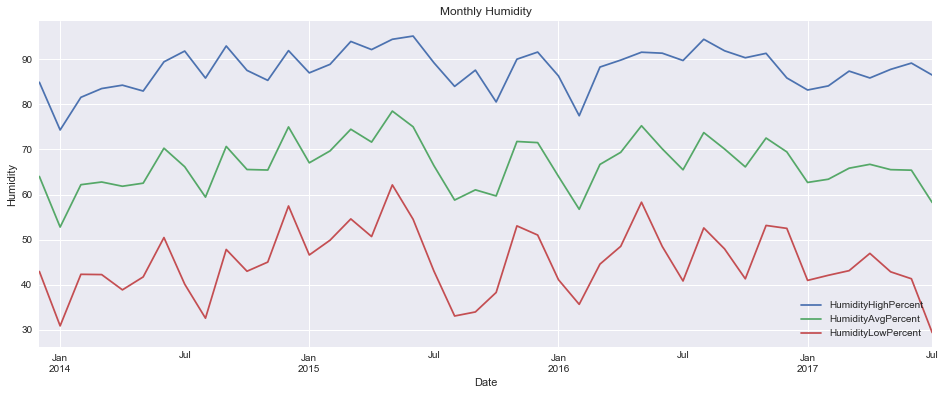

In [50]:
df[['HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent']].resample('M').mean().plot(title='Monthly Humidity', figsize=(16, 6))

plt.ylabel('Humidity')
plt.show()

Humidity does not vary much across time in Austin. Above, we see high, mean, and low humidity values averaged by month. Lets quantify this variation a bit more.

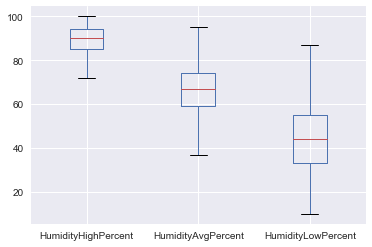

In [51]:
df[['HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent']].plot.box()
plt.show()

In [52]:
q3 = df[['HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent']].quantile(.75)
q1 = df[['HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent']].quantile(.25)

iqr = q3-q1

iqr

HumidityHighPercent     9.0
HumidityAvgPercent     15.0
HumidityLowPercent     22.0
dtype: float64

The blox plot demonstrates the lower variability in humidity across time. Most of the high and average daily humidity values are contained within a small range of the median of the data. The daily humidity highs also have many outliers below 70% and all the way to 40% humidity.

We print out the interquartile ranges of the humidity features. Notice, the middle 50% of the HumidityAvgPercent variable is contained within a range of 15% humidity.

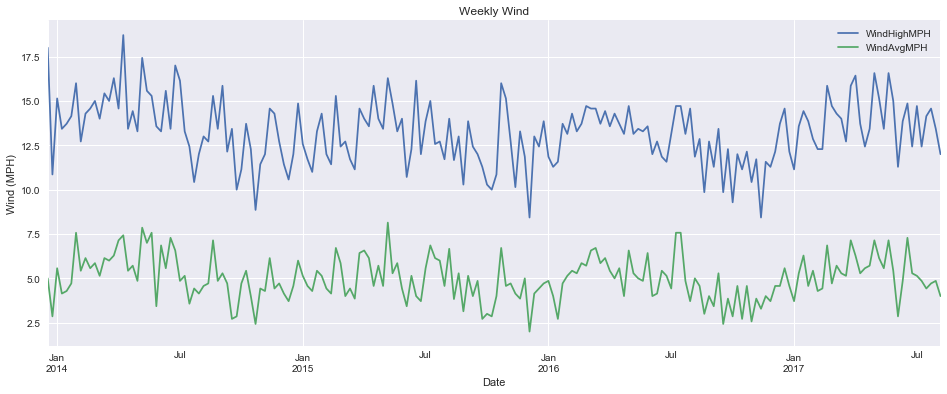

In [54]:
df[['WindHighMPH', 'WindAvgMPH']].resample('W').mean().plot(title='Weekly Wind', figsize=(16, 6))

plt.ylabel('Wind (MPH)')
plt.show()

If we plot the mean weekly wind, we notice a seasonal pattern. Winds increase from February through August each year, with highs around May and June. The winds die down after this period and hit lows in November and December of each year.